In [2]:
import argparse
import copy
import itertools
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import progressbar
import pickle
import os.path as op
import scipy.io as sio
import seaborn as sns
import sys

from IPython.core.display import display, HTML
from mat2py import mat2py
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression
import sklearn.manifold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import r2_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

%matplotlib inline

def compute_metrics(classifier, testing_data, threshold=0.5):
    metrics = {}
    metric = {}
    rf = classifier['classifier']
    
    score_class = lambda score: 1 if score>threshold else 0
    fix_score = lambda score: 1 if score==1. else 0
    
    oob_class = [score_class(proba) for proba in rf.oob_decision_function_[:,0]]
    oob_scores = [fix_score(score) for score in classifier['scores']]
    
    fpr, tpr , thresholds= roc_curve(classifier['scores'], 
                                     rf.oob_decision_function_[:,0], 
                                     pos_label = 1)
    metric['AUC'] = auc(fpr, tpr)
    tidx = np.abs(thresholds-threshold).argmin()
    metric['FPR'] = fpr[tidx]
    metric['Recall'] = recall_score(oob_scores, oob_class)
    metric['Precision'] = precision_score(oob_scores, oob_class)
    metric['Accuracy'] = accuracy_score(oob_scores, oob_class)
    
    metrics['oob'] = metric
    
    for dataset in testing_data:
        metric = {}
        probas = rf.predict_proba(testing_data[dataset]['heldout_data'][:,1:])
        classes = [score_class(proba) for proba in probas[:,0]]
        scores = [fix_score(score) for score in testing_data[dataset]['heldout_data'][:,0]]
        fpr, tpr , thresholds= roc_curve(scores, 
                                     probas[:,0], 
                                     pos_label = 1)
        metric['AUC'] = auc(fpr, tpr)
        tidx = np.abs(thresholds-threshold).argmin()
        metric['FPR'] = fpr[tidx]
        metric['Recall'] = recall_score(scores, classes)
        metric['Precision'] = precision_score(scores, classes)
        metric['Accuracy'] = accuracy_score(scores, classes)
        
        metrics[dataset] = metric
    
    return metrics

def color_scale(val, low, high):
    num_vals = 10
    cmap = sns.color_palette("RdBu_r", num_vals).as_hex()
    val_range=np.linspace(low,high,num_vals)
    idx = np.abs(val_range-val).argmin()
    return 'background-color: %s' % (cmap[idx])

def plot_roc_and_pr_curves(rf, dataset_name,
                      rf_training_scores,
                      all_heldout_scores, all_heldout_features,
                      B2_heldout_scores, B2_heldout_features,
                      MOR_heldout_scores, MOR_heldout_features,
                      TfR_heldout_scores, TfR_heldout_features):
    fig, [ax1, ax2] = plt.subplots(1,2,figsize=(12,5))
    fig.suptitle(cargo, y=1.02, fontsize=20)
    ax1.set_xlabel('1-Specificty')
    ax1.set_ylabel('Sensitivity')
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    
    # Out of Bag
    fpr, tpr , thresholds= roc_curve(rf_training_scores, rf.oob_decision_function_[:,0], pos_label = 1)
    ax1.plot(fpr,tpr,'grey',label=dataset_name + ' OOB Sample')
    precision, recall, thresholds = precision_recall_curve(rf_training_scores, rf.oob_decision_function_[:,0],pos_label = 1)
    ax2.plot(recall,precision, 'grey', label=dataset_name + ' OOB Sample')
    
    #Global
    probas_ = rf.predict_proba(all_heldout_features)
    fpr, tpr , thresholds= roc_curve(all_heldout_scores, probas_[:,0], pos_label = 1)
    ax1.plot(fpr,tpr,'black',label='Global Held-Out Sample')
    precision, recall, thresholds = precision_recall_curve(all_heldout_scores, probas_[:,0],pos_label = 1)
    ax2.plot(recall,precision, 'black', label='Global Held-Out Sample')
    
    #B2
    probas_ = rf.predict_proba(B2_heldout_features)
    fpr, tpr , thresholds= roc_curve(B2_heldout_scores, probas_[:,0], pos_label = 1)
    ax1.plot(fpr,tpr,'goldenrod', ls='--', label='B2 Held-Out Sample')
    precision, recall, thresholds = precision_recall_curve(B2_heldout_scores, probas_[:,0],pos_label = 1)
    ax2.plot(recall,precision, 'goldenrod', ls='--', label='B2 Held-Out Sample')
    
    #MOR
    probas_ = rf.predict_proba(MOR_heldout_features)
    fpr, tpr , thresholds= roc_curve(MOR_heldout_scores, probas_[:,0], pos_label = 1)
    ax1.plot(fpr,tpr,'blue', ls='--', label='MOR Held-Out Sample')
    precision, recall, thresholds = precision_recall_curve(MOR_heldout_scores, probas_[:,0],pos_label = 1)
    ax2.plot(recall,precision, 'blue', ls='--', label='MOR Held-Out Sample')
    
    #TfR
    probas_ = rf.predict_proba(TfR_heldout_features)
    fpr, tpr , thresholds= roc_curve(TfR_heldout_scores, probas_[:,0], pos_label = 1)
    ax1.plot(fpr,tpr,'purple', ls='--', label='TfR Held-Out Sample')
    precision, recall, thresholds = precision_recall_curve(TfR_heldout_scores, probas_[:,0],pos_label = 1)
    ax2.plot(recall,precision, 'purple', ls='--', label='TfR Held-Out Sample')

    ax1.legend()
    ax2.legend()
    ax1.set_title(dataset_name + ' ROC Curve')
    ax2.set_title(dataset_name + ' PR Curve')

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [38]:
#dump session
with open('puffsAnalysis.pkl', 'wb') as f:
    pickle.dump([cargoes, classifiers], f, protocol=1)

In [2]:
with open('puffsAnalysis.pkl', 'rb') as f:
    [cargoes, classifiers] = pickle.load(f)

In [41]:
cargoes['all']['data'].to_csv(path_or_buf='all_data.csv')
cargoes['all']['training_data'].to_csv(path_or_buf='all_training.csv')
cargoes['all']['heldout_data'].to_csv(path_or_buf='all_heldout.csv')

In [42]:
joblib.dump(classifiers['all']['classifier'], 'RFfile', compress=True)

['RFfile']

In [ ]:
def save_as_pickled_object(obj, filepath):
    """
    This is a defensive way to write pickle.write, allowing for very large files on all platforms
    """
    max_bytes = 2**31 - 1
    bytes_out = pickle.dumps(obj)
    n_bytes = sys.getsizeof(bytes_out)
    with open(filepath, 'wb') as f_out:
        for idx in range(0, n_bytes, max_bytes):
            f_out.write(bytes_out[idx:idx+max_bytes])

export_obj = [cargoes, classifiers,
              all_gm, puffs_gm, nonpuffs_gm, 
              fit_mds_all, fit_mds_puffs, fit_mds_nonpuffs, 
              fit_tsne_all, fit_tsne_puffs, fit_tsne_nonpuffs]
            
save_as_pickled_object(export_obj, 'puffsAnalysis.pkl')

In [ ]:
def try_to_load_as_pickled_object_or_None(filepath):
    """
    This is a defensive way to write pickle.load, allowing for very large files on all platforms
    """
    max_bytes = 2**31 - 1
    try:
        input_size = os.path.getsize(filepath)
        bytes_in = bytearray(0)
        with open(filepath, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        obj = pickle.loads(bytes_in)
    except:
        return None
    return obj

[cargoes, classifiers,
    all_gm, puffs_gm, nonpuffs_gm, 
    fit_mds_all, fit_mds_puffs, fit_mds_nonpuffs, 
    fit_tsne_all, fit_tsne_puffs, fit_tsne_nonpuffs] = try_to_load_as_pickled_object_or_None('puffsAnalysis.pkl')

In [16]:
#load in MATLAB data
def load_mat_files(name, condition, fields, split = 'within_cell'):
    # split "within_cell" will split each cell in half, to training and heldout
    # split "in_half" will evenly split the total tracks in a condition across training and heldout
    # split "intelligently" will order cells by mean background and then split cells down the list between training and heldout
    shape = (0,len(fields))
    cargo = {'data' : pd.DataFrame(columns=fields),
             'training_data' : pd.DataFrame(columns=fields),
             'heldout_data' : pd.DataFrame(columns=fields)}
    
    data_list = [];
    training_list = [];
    heldout_list = [];
    
    bar = progressbar.ProgressBar()
    for file in bar(condition['files']):
        data = mat2py(condition['dir'] + file + '.mat', fields, condition['dir'], file)
        data = pd.DataFrame(np.nan_to_num(np.array(data.tolist())),
                            columns=fields,
                            index=pd.Index(np.r_[1:np.shape(data)[0]+1],name='track'))
        if split == 'within_cell':
            puffs = data[data.isPuff==1.]
            nonpuffs = data[data.isPuff==2.]
            r = np.random.RandomState(327)
            puff_mask = r.choice([True, False], puffs.shape[0], p=[0.5, 0.5])
            nonpuff_mask = r.choice([True, False], nonpuffs.shape[0], p=[0.5, 0.5])
            training_data = pd.concat([puffs[puff_mask], nonpuffs[nonpuff_mask]])
            heldout_data = pd.concat([puffs[[not x for x in puff_mask]], nonpuffs[[not x for x in nonpuff_mask]]])
            data_list.append(data)
            training_list.append(training_data)
            heldout_list.append(heldout_data)
        else:
            data_list.append(data)
        
    if split == 'within_cell':
        cargo['data'] = pd.concat(data_list, keys=condition['files'], names=['cell'])
        cargo['training_data'] = pd.concat(training_list, keys=condition['files'], names=['cell'])
        cargo['heldout_data'] = pd.concat(heldout_list, keys=condition['files'], names=['cell'])
    elif split == 'in_half':
        data = pd.concat(data_list, keys=condition['files'], names=['cell'])
        half_frame = int(np.shape(data)[0]/2)
        training_data = data.iloc[0:half_frame,:]
        heldout_data = data.iloc[half_frame+1:,:]
        cargo['data'] = data
        cargo['training_data'] = training_data
        cargo['heldout_data'] = heldout_data
    elif split == 'intelligently':
        data = pd.concat(data_list, keys=condition['files'], names=['cell'])
        global_background = {};
        for cell in np.unique(data.index.get_level_values('cell')):
            cell_data = data.xs(cell, level=0)
            global_background[cell] = np.mean(cell_data['global_background'])
        sorted_by_background = [data.xs(k, level=0) for k in sorted(global_background, 
                                                                    key=global_background.get)]
        cargo['data'] = data
        cargo['training_data'] = pd.concat(sorted_by_background[::2], keys=condition['files'], names=['cell'])
        cargo['heldout_data'] = pd.concat(sorted_by_background[1::2], keys=condition['files'], names=['cell'])
    return cargo

In [32]:
fields = ['isPuff', 'hpeaks', 'php', 'cdiff', 'pfallR2', 'pvp', 'pallAcdiff', 'npeaks', 'tnpeaks', 'lifetime_s', 
          'percentC','MotionAnalysis', 'deltaf', 'SNR', 'tau', 'ttp', 'RSSm', 'global_background', 'plateau', 'int_density']
conditions = {'TfR' : {'dir' : '/Volumes/Coatamer/Users/weinberz/CMU Drive/Data/Puffs Analysis/TfR Puffs/',
                       'files' : ['scoredTracksTfRRachelCell14',
                                  'scoredTracksTfRRachelCell8',
                                  'scoredTracksTfRRachelCell17',
                                  'scoredTracksTfRRachelCell10',
                                  'scoredTracksTfRZYWCell13',
                                  'scoredTracksTfRZYWCell2',
                                  'scoredTracksTfRZYWCell6']},
              'MOR' : {'dir' : '/Volumes/Coatamer/Users/weinberz/CMU Drive/Data/Puffs Analysis/2016 Washout Jenny/WTMOR/',
                       'files' : ['scoredTracksMORCell1',
                                  'scoredTracksMORCell2',
                                  'scoredTracksMORCell5',
                                  'scoredTracksMORCell8',
                                  'scoredTracksMORCell18',
                                  'scoredTracksMORCell22']},
              'B2' : {'dir' : '/Volumes/Coatamer/Users/weinberz/CMU Drive/Data/Puffs Analysis/Rachel B2 Puffs/',
                      'files' : ['scoredTracksB2Cell11',
                                 'scoredTracksB2Cell12',
                                 'scoredTracksB2Cell14',
                                 'scoredTracksB2Cell3',
                                 'scoredTracksB2Cell4',
                                 'scoredTracksB2Cell26']}}

In [26]:
cargoes = {}
for name, condition in conditions.items():
    cargoes[name] = load_mat_files(name, condition, fields)
    
cargoes['all'] = {'data' : pd.concat([cargoes[cargo]['data'] for cargo in conditions], 
                                     keys=[cargo for cargo in conditions],
                                     names=['cargo']),
                  'training_data' : pd.concat([cargoes[cargo]['training_data'] for cargo in conditions], 
                                     keys=[cargo for cargo in conditions],
                                     names=['cargo']),
                  'heldout_data' : pd.concat([cargoes[cargo]['heldout_data'] for cargo in conditions], 
                                     keys=[cargo for cargo in conditions],
                                     names=['cargo'])}

In [33]:
cargoes = {}
for name, condition in conditions.items():
    cargoes[name] = load_mat_files(name, condition, fields, split='intelligently')
    
cargoes['all'] = {'data' : pd.concat([cargoes[cargo]['data'] for cargo in conditions], 
                                     keys=[cargo for cargo in conditions],
                                     names=['cargo']),
                  'training_data' : pd.concat([cargoes[cargo]['training_data'] for cargo in conditions], 
                                     keys=[cargo for cargo in conditions],
                                     names=['cargo']),
                  'heldout_data' : pd.concat([cargoes[cargo]['heldout_data'] for cargo in conditions], 
                                     keys=[cargo for cargo in conditions],
                                     names=['cargo'])}

100% (7 of 7) |###########################| Elapsed Time: 0:01:16 Time: 0:01:16
100% (6 of 6) |###########################| Elapsed Time: 0:00:54 Time: 0:00:54
100% (6 of 6) |###########################| Elapsed Time: 0:01:19 Time: 0:01:19


<function matplotlib.pyplot.show>

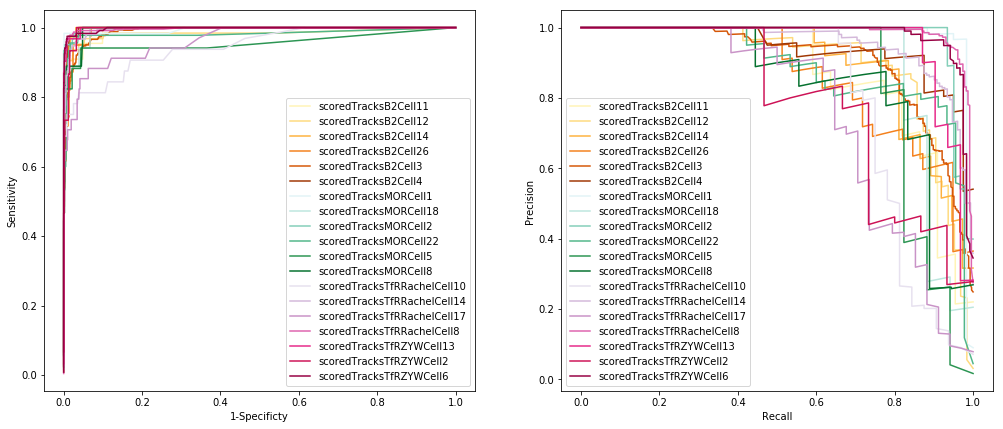

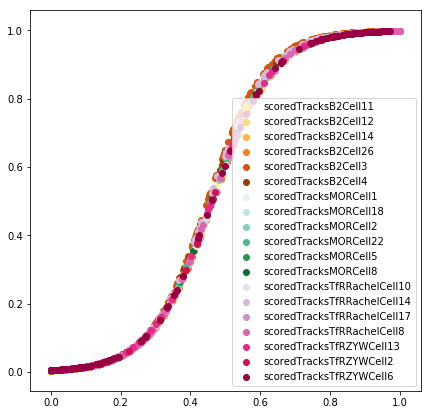

In [24]:
pal = sns.color_palette('YlOrBr',6)+sns.color_palette('BuGn',6)+sns.color_palette('PuRd',7)
sns.set_palette(pal)

plt.figure(figsize=(17,7))
ax1 = plt.subplot(121)
ax1.set_xlabel('1-Specificty')
ax1.set_ylabel('Sensitivity')
ax2 = plt.subplot(122)
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')

fh, ax3 = plt.subplots(figsize=(7,7))

rr = dict()

training_fields = ['hpeaks', 'php', 'cdiff', 'pfallR2', 'pvp', 'pallAcdiff', 'npeaks', 
                   'tnpeaks', 'percentC','MotionAnalysis', 'ttp', 'RSSm', 'deltaf',
                   'global_background', 'SNR', 'lifetime_s']

for cell in np.unique(cargoes['all']['data'].index.get_level_values('cell')):
    held_data = cargoes['all']['data'].xs(cell, level=1)
    train_data = cargoes['all']['data'][cargoes['all']['data'].index.get_level_values('cell') != cell]
    classifier = RandomForestClassifier(
        n_estimators = 2000, 
        oob_score = True, 
        class_weight="balanced", 
        random_state=237,
        n_jobs=4)
    classifier.fit(train_data[training_fields], train_data['isPuff'])
    probas_ = classifier.predict_proba(held_data[training_fields])
    fpr, tpr , thresholds= roc_curve(held_data['isPuff'], probas_[:,0], pos_label = 1)
    ax1.plot(fpr, tpr, label=cell)
    precision, recall, thresholds = precision_recall_curve(held_data['isPuff'], probas_[:,0],pos_label = 1)
    ax2.plot(recall, precision, label=cell)
    calibrater = LogisticRegression(C = 1000000, random_state=237)
    calibrater.fit(classifier.oob_decision_function_[:,0].reshape(-1, 1), train_data['isPuff'])
    proba_calibrated = calibrater.predict_proba(probas_[:,0].reshape(-1, 1))
    ax3.scatter(probas_[:,0], proba_calibrated[:,0], label=cell)
    held_data = pd.concat([held_data, 
                           pd.DataFrame(pd.Series(probas_[:,0], 
                                                  index=held_data.index,
                                                  name='proba')),
                           pd.DataFrame(pd.Series(proba_calibrated[:,0], 
                                                  index=held_data.index,
                                                  name='proba_cal'))],
                          axis=1)
    rr[cell] = held_data

ax1.legend()
ax2.legend()
ax3.legend()
plt.show

In [29]:
cells = np.unique(cargoes['all']['data'].index.get_level_values('cell'))
round_robin_df = pd.concat([rr[cell] for cell in cells], keys=[cell for cell in cells], names=['cell']).reorder_levels(['cargo', 'cell', 'track'])
round_robin_df.to_csv('round_robin.csv')

In [3]:
rr_sane = pd.read_csv('rr_sane.csv')

In [6]:
round_robin_df = pd.read_csv('round_robin.csv')

In [5]:
def correction(train_y, train_f, test_f, thresh=0.5):
    _, train_props = np.unique(train_y, return_counts=True)
    train_props = train_props/len(train_y)
    train_conf = pd.crosstab(index=train_f>thresh, columns=train_y)
    train_conf = train_conf/train_conf.values.sum()
    _, test_pred_props = np.unique(test_f>thresh, return_counts=True)
    test_pred_props = test_pred_props/len(test_f)
    w = np.matmul(np.linalg.solve(train_conf, np.identity(2)), test_pred_props)
    muy = train_props*w
    return muy[0]

In [6]:
cell_res = pd.DataFrame({'cell': np.unique(rr_sane['cell'])})

for cell in cell_res['cell']:
    train = rr_sane.loc[rr_sane['cell'] != cell]
    test = rr_sane.loc[rr_sane['cell'] == cell]
    
    cell_res.loc[cell_res['cell'] == cell ,'est_frac'] = correction(train['isPuff'], train['proba'], test['proba'], thresh = 0.3)
    cell_res.loc[cell_res['cell'] == cell , 'true_count'] = np.sum(test['isPuff'] == 1.)
    cell_res.loc[cell_res['cell'] == cell , 'true_frac'] = np.mean(test['isPuff'] == 1.)

    cell_res.loc[cell_res['cell'] == cell , 'n'] = test.shape[0]
    
    cell_res.loc[cell_res['cell'] == cell , 'simple'] = np.mean(test['proba'])
    
cell_res

,cell,est_frac,true_count,true_frac,n,simple
0,scoredTracksB2Cell11,0.046858,22.0,0.027500,800.0,0.039387
1,scoredTracksB2Cell12,0.023931,63.0,0.030928,2037.0,0.026714
2,scoredTracksB2Cell14,0.007381,37.0,0.014269,2593.0,0.013950
3,scoredTracksB2Cell26,0.044688,39.0,0.038500,1013.0,0.044214
4,scoredTracksB2Cell3,0.069434,266.0,0.060758,4378.0,0.059758
5,scoredTracksB2Cell4,0.064864,40.0,0.042781,935.0,0.053273
6,scoredTracksMORCell1,0.026670,60.0,0.029718,2019.0,0.030281
7,scoredTracksMORCell18,0.027218,17.0,0.016798,1012.0,0.030460
8,scoredTracksMORCell2,0.027514,61.0,0.030409,2006.0,0.029360
9,scoredTracksMORCell22,0.043425,45.0,0.044554,1010.0,0.035503


In [152]:
rr_sane.loc[(rr_sane['cell'] == 'scoredTracksTfRZYWCell2') & (rr_sane['isPuff'] == 1.),['proba', 'proba_cal']]

,proba,proba_cal
27701,0.2240,0.062101
27727,0.4210,0.385132
27812,0.2730,0.103774
27815,0.4710,0.525603
27841,0.0380,0.007872
27877,0.0770,0.012229
27900,0.0950,0.014975
28132,0.0900,0.014156
28165,0.5160,0.649260
28307,0.4185,0.378402


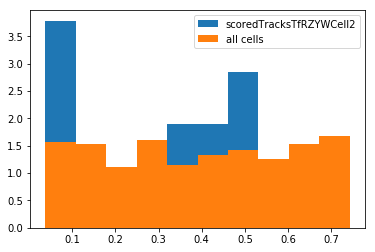

In [149]:
_, bins, _ = plt.hist(rr_sane.loc[(rr_sane['cell'] == 'scoredTracksTfRZYWCell2') & (rr_sane['isPuff'] == 1.), 'proba'],density=True, label = 'scoredTracksTfRZYWCell2')
plt.hist(rr_sane.loc[(rr_sane['cell'] != 'scoredTracksTfRZYWCell2') & (rr_sane['isPuff'] == 1.), 'proba'],bins = bins, density=True, label = 'all cells')
plt.legend()

In [7]:
%reload_ext rpy2.ipython
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
%R library(tidyverse)

array(['forcats', 'stringr', 'dplyr', 'purrr', 'readr', 'tidyr', 'tibble',
       'ggplot2', 'tidyverse', 'tools', 'stats', 'graphics', 'grDevices',
       'utils', 'datasets', 'methods', 'base'], dtype='<U9')

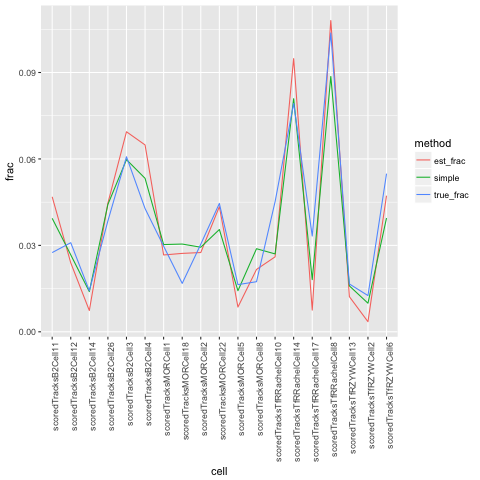

In [8]:
%%R -i cell_res
cell_res_tall = gather(cell_res, "method","frac",c(-cell,-true_count, -n))
ggplot(cell_res_tall, aes(x=cell, y=frac, color=method, group=method)) + geom_line()+  theme(axis.text.x = element_text(angle = 90, hjust = 1))

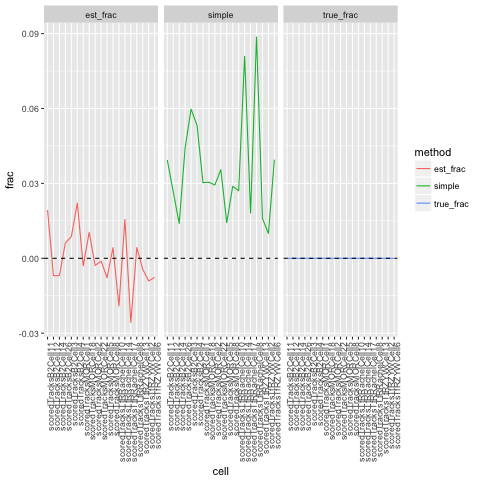

In [9]:
%%R
frac_guess_demean = cell_res
for(j in 2:ncol(frac_guess_demean)){
  frac_guess_demean[,j] = frac_guess_demean[,j]-frac_guess_demean$true_frac
}
frac_guess_demean = frac_guess_demean[,-7]
frac_guess_demean_tall = gather(frac_guess_demean, "method","frac",c(-cell,-true_count, -n))
ggplot(frac_guess_demean_tall, aes(x=cell, y=frac, color=method, group=method)) + geom_line()+  theme(axis.text.x = element_text(angle = 90, hjust = 1)) + geom_hline(yintercept=0, lty=2)+facet_wrap(~method)

In [10]:
for cell in np.unique(rr_sane['cell']):
    est_frac = cell_res.loc[cell_res['cell'] == cell, 'est_frac'].values[0]
    train_prior = rr_sane.loc[(rr_sane['cell'] == cell) & (rr_sane['isPuff'] == 1.)].shape[0] / rr_sane.loc[(rr_sane['cell'] == cell)].shape[0]
    rr_sane.loc[rr_sane['cell'] == cell, 'prior'] = est_frac
    rr_sane.loc[rr_sane['cell'] == cell, 'train_prior'] = train_prior

In [11]:
def score_correct(probs_old, pi_old, pi_new):
    return pi_new/pi_old*probs_old/(pi_new/pi_old*probs_old + (1-pi_new)/(1-pi_old)*(1-probs_old))

In [12]:
rr_sane['proba_fixed'] = score_correct(rr_sane['proba'], rr_sane['train_prior'], rr_sane['prior'])
rr_sane['proba_fixedc'] = score_correct(rr_sane['proba_cal'], rr_sane['train_prior'], rr_sane['prior'])

# A tibble: 3 x 5
  cargo lifetime_raw lifetime_weightedc lifetime_weighted lifetime_true
  <chr>        <dbl>              <dbl>             <dbl>         <dbl>
1 B2           0.862               1.11              1.12          1.13
2 MOR          0.960               1.03              1.03          1.11
3 TfR          1.16                1.15              1.26          1.14


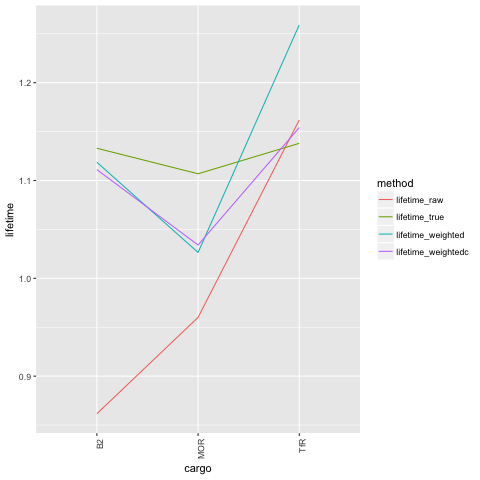

In [13]:
%%R -i rr_sane
dat = rr_sane
dat$isPuff = as.factor(1-(dat$isPuff-1))
dat$isPuffnum = as.numeric(as.character(dat$isPuff))
lifetimes = dat %>% group_by(cargo) %>% summarize(lifetime_raw = mean(lifetime_s), lifetime_weightedc = weighted.mean(lifetime_s, proba_fixedc), lifetime_weighted = weighted.mean(lifetime_s, proba_fixed), lifetime_true = weighted.mean(lifetime_s, w=isPuffnum))
print(lifetimes)

lifetimes_tall = gather(lifetimes, "method","lifetime",c(-cargo))
ggplot(lifetimes_tall, aes(x=cargo, y=lifetime, color=method, group=method)) + geom_line()+  theme(axis.text.x = element_text(angle = 90, hjust = 1))

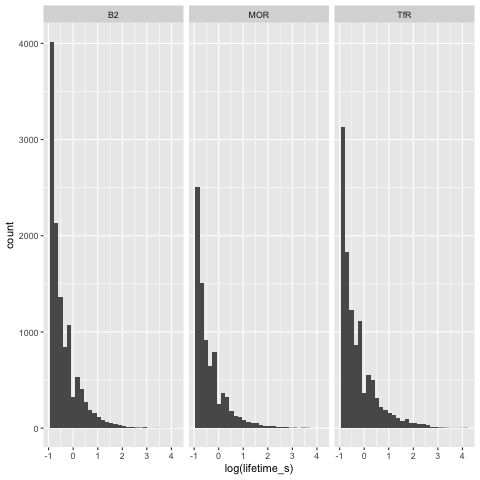

In [14]:
%%R
ggplot(dat, aes(x=log(lifetime_s))) + geom_histogram(bins=30) + facet_wrap(~cargo)

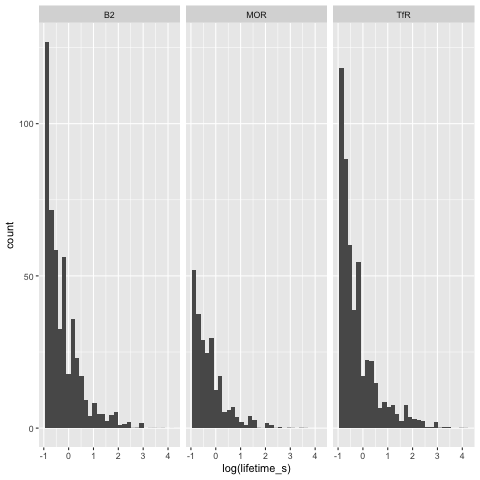

In [15]:
%%R
ggplot(dat, aes(x=log(lifetime_s), weight=proba_fixed)) + geom_histogram(bins=30) + facet_wrap(~cargo)

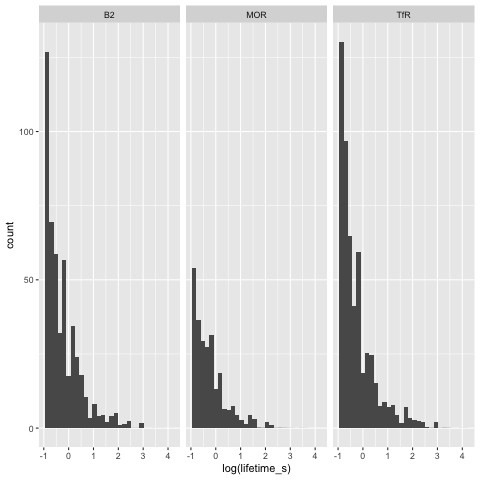

In [16]:
%%R
ggplot(dat, aes(x=log(lifetime_s), weight=proba_fixedc)) + geom_histogram(bins=30) + facet_wrap(~cargo)

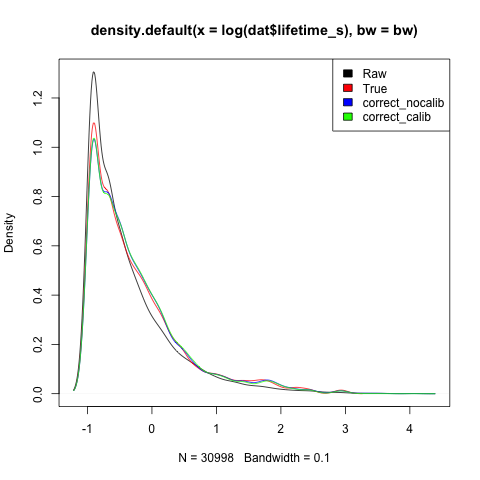

In [17]:
%%R

bw = 0.1
plot(density(log(dat$lifetime_s),bw=bw))
lines(density(log(dat$lifetime_s[which(dat$isPuff==1)]),bw=bw),col='red')
#Weights based on our two corrected probabilities
wgts = pmax(0,dat$proba_fixed)
wgts2 = pmax(0,dat$proba_fixedc)
#Normalize the weights
wgts = wgts / sum(wgts)
wgts2 = wgts2 / sum(wgts2) 
#Make weighted density estimates.
lines(density(log(dat$lifetime_s), weights = wgts,bw=bw),col='blue')
lines(density(log(dat$lifetime_s), weights = wgts2,bw=bw),col='green')
#grab current axis limits and use them later
xlim = par('usr')[1:2]

legend('topright',fill=c('black','red','blue','green'), legend=c('Raw','True','correct_nocalib','correct_calib'))

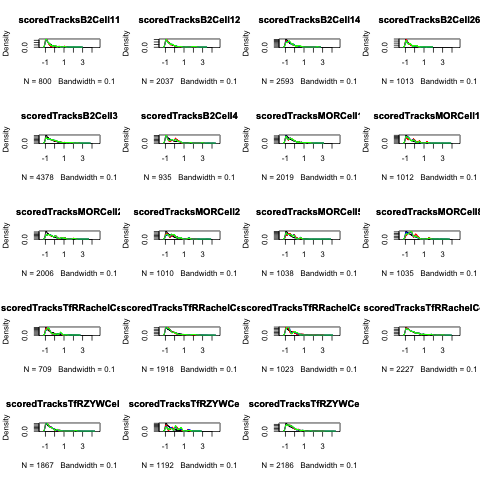

In [19]:
%%R

cell_list = unique(dat$cell)
ncell = length(cell_list)

par(mfrow=c(5,4))
for (k in 1:ncell){
  cellname = cell_list[k]
  
  dats = subset(dat, dat$cell == cellname)
  bw = 0.1
  plot(density(log(dats$lifetime_s),bw=bw), xlim=xlim, main=cellname)
  lines(density(log(dats$lifetime_s[which(dats$isPuff==1)]),bw=bw),col='red')
  wgts = pmax(0,dats$proba_fixed)
  wgts2 = pmax(0,dats$proba_fixedc)
  
  wgts = wgts / sum(wgts)
  wgts2 = wgts2 / sum(wgts2)
  lines(density(log(dats$lifetime_s), weights = wgts,bw=bw),col='blue')
  lines(density(log(dats$lifetime_s), weights = wgts2,bw=bw),col='green')
  title(cellname)
}

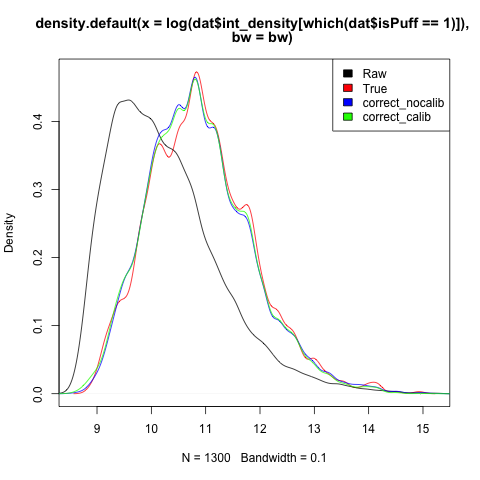

In [21]:
%%R

bw = 0.1

plot(density(log(dat$int_density[which(dat$isPuff==1)]),bw=bw),col='red')
lines(density(log(dat$int_density),bw=bw))
wgts = pmax(0,dat$proba_fixed)
wgts2 = pmax(0,dat$proba_fixedc)
wgts = wgts / sum(wgts)
wgts2 = wgts2 / sum(wgts2)
lines(density(log(dat$int_density), weights = wgts,bw=bw),col='blue')
lines(density(log(dat$int_density), weights = wgts2,bw=bw),col='green')
#grab current axis limits and use them later
xlim = par('usr')[1:2]

legend('topright',fill=c('black','red','blue','green'), legend=c('Raw','True','correct_nocalib','correct_calib'))

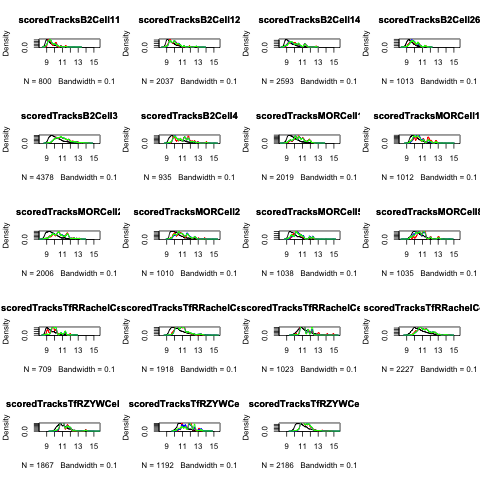

In [23]:
%%R

cell_list = unique(dat$cell)
ncell = length(cell_list)
par(mfrow=c(5,4))
for (k in 1:ncell){
  cellname = cell_list[k]

  dats = subset(dat, dat$cell == cellname)
  bw = 0.1
  plot(density(log(dats$int_density),bw=bw), xlim=xlim, main=cellname)
  lines(density(log(dats$int_density[which(dats$isPuff==1)]),bw=bw),col='red')
  wgts = pmax(0,dats$proba_fixed)
  wgts2 = pmax(0,dats$proba_fixedc)
  
  wgts = wgts / sum(wgts)
  wgts2 = wgts2 / sum(wgts2)
  lines(density(log(dats$int_density), weights = wgts,bw=bw),col='blue')
  lines(density(log(dats$int_density), weights = wgts2,bw=bw),col='green')
  
  title(cellname)
}

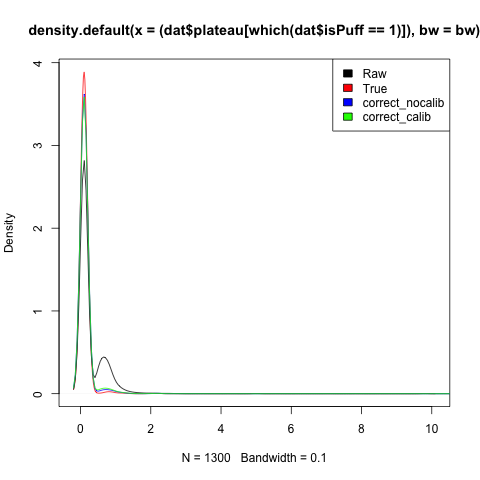

In [24]:
%%R

bw = 0.1
par(mfrow=c(1,1))
plot(density((dat$plateau[which(dat$isPuff==1)]),bw=bw),col='red')
lines(density((dat$plateau),bw=bw))
wgts = pmax(0,dat$proba_fixed)
wgts2 = pmax(0,dat$proba_fixedc)

wgts = wgts / sum(wgts)
wgts2 = wgts2 / sum(wgts2)
lines(density((dat$plateau), weights = wgts,bw=bw),col='blue')
lines(density((dat$plateau), weights = wgts2,bw=bw),col='green')
#grab current axis limits and use them later
xlim = par('usr')[1:2]

legend('topright',fill=c('black','red','blue','green'), legend=c('Raw','True','correct_nocalib','correct_calib'))

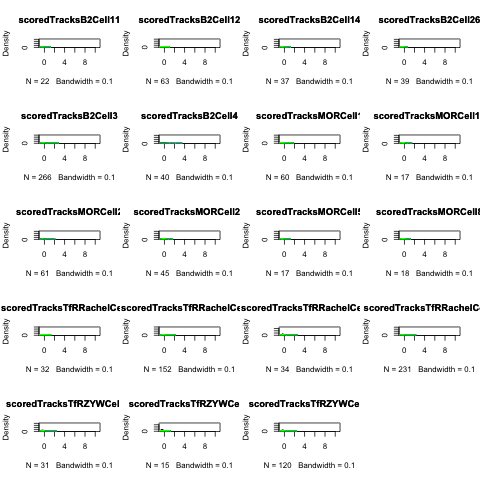

In [25]:
%%R

cell_list = unique(dat$cell)
ncell = length(cell_list)
par(mfrow=c(5,4))
for (k in 1:ncell){
  cellname = cell_list[k]

  dats = subset(dat, dat$cell == cellname)
  bw = 0.1
  
  plot(density(log(dats$plateau[which(dats$isPuff==1)]),bw=bw),col='red', xlim=xlim, main=cellname)
  lines(density(log(dats$plateau),bw=bw))
  wgts = pmax(0,dats$proba_fixed)
  wgts2 = pmax(0,dats$proba_fixedc)
  
  wgts = wgts / sum(wgts)
  wgts2 = wgts2 / sum(wgts2)

  lines(density(log(dats$plateau), weights = wgts,bw=bw),col='blue')
  lines(density(log(dats$plateau), weights = wgts2,bw=bw),col='green')
  title(cellname)
}

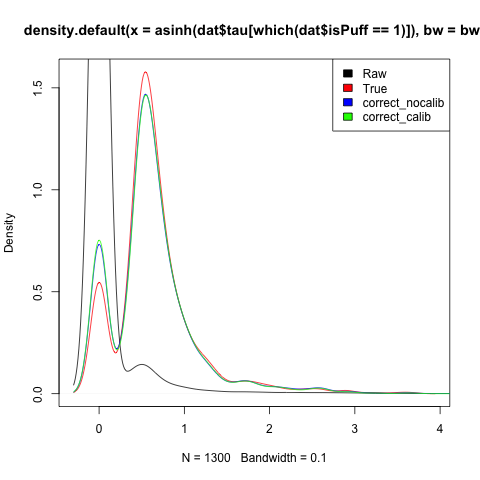

In [26]:
%%R

bw = 0.1
par(mfrow=c(1,1))
plot(density(asinh(dat$tau[which(dat$isPuff==1)]),bw=bw),col='red')
lines(density(asinh(dat$tau),bw=bw))
wgts = pmax(0,dat$proba_fixed)
wgts2 = pmax(0,dat$proba_fixedc)

wgts = wgts / sum(wgts)
wgts2 = wgts2 / sum(wgts2)
lines(density(asinh(dat$tau), weights = wgts,bw=bw),col='blue')
lines(density(asinh(dat$tau), weights = wgts2,bw=bw),col='green')
#grab current axis limits and use them later
xlim = par('usr')[1:2]

legend('topright',fill=c('black','red','blue','green'), legend=c('Raw','True','correct_nocalib','correct_calib'))

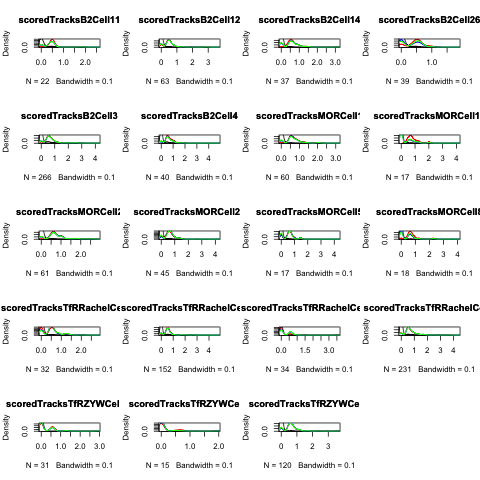

In [27]:
%%R

cell_list = unique(dat$cell)
ncell = length(cell_list)
par(mfrow=c(5,4))
for (k in 1:ncell){
  cellname = cell_list[k]

  dats = subset(dat, dat$cell == cellname)
  bw = 0.1
  
  xlim = range(asinh(dats$tau))
  plot(density(asinh(dats$tau[which(dats$isPuff==1)]),bw=bw),col='red',xlim=xlim, main=cellname)
  lines(density(asinh(dats$tau),bw=bw))
  wgts = pmax(0,dats$proba_fixed)
  wgts2 = pmax(0,dats$proba_fixedc)
  
  wgts = wgts / sum(wgts)
  wgts2 = wgts2 / sum(wgts2)

  lines(density(asinh(dats$tau), weights = wgts,bw=bw),col='blue')
  lines(density(asinh(dats$tau), weights = wgts2,bw=bw),col='green')
  title(cellname)
}

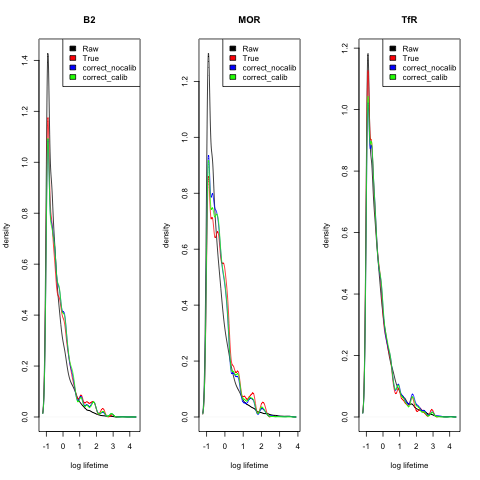

In [29]:
%%R

bw = 0.1
cargoes = c('B2','MOR','TfR')
par(mfrow=c(1,3))

for (i in 1:length(cargoes)){
  cargo = cargoes[i]
  idx = which(dat$cargo == cargo)
  datsub = dat[idx,]
  plot(density(log(datsub$lifetime_s),bw=bw), xlab='log lifetime', ylab='density', main=cargo)
  lines(density(log(datsub$lifetime_s[which(datsub$isPuff==1)]),bw=bw),col='red')
  #Weights based on our two corrected probabilities
  wgts = pmax(0,datsub$proba_fixed)
  wgts2 = pmax(0,datsub$proba_fixedc)
  #Normalize the weights
  wgts = wgts / sum(wgts)
  wgts2 = wgts2 / sum(wgts2)  
  #Make weighted density estimates. 
  lines(density(log(datsub$lifetime_s), weights = wgts,bw=bw),col='blue')
  lines(density(log(datsub$lifetime_s), weights = wgts2,bw=bw),col='green')
  legend('topright',fill=c('black','red','blue','green'),  legend=c('Raw','True','correct_nocalib','correct_calib'))
}

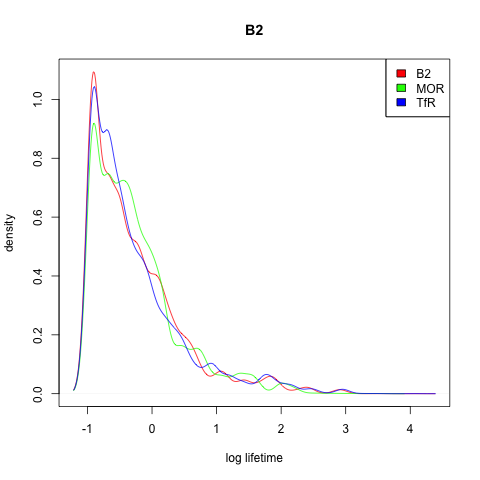

In [30]:
%%R

bw = 0.1
cargoes = c('B2','MOR','TfR')
par(mfrow=c(1,1))

colors =c('red','green','blue')
for (i in 1:length(cargoes)){
  cargo = cargoes[i]
  idx = which(dat$cargo == cargo)
  datsub = dat[idx,]
  wgts2 = pmax(0,datsub$proba_fixedc)
  wgts2 = wgts2 / sum(wgts2)  
  if(i==1){
    plot(density(log(datsub$lifetime_s),weights = wgts2, bw=bw), xlab='log lifetime', ylab='density', main=cargo, col=colors[i])
  } else {
    lines(density(log(datsub$lifetime_s), weights = wgts2,bw=bw), main=cargo, col=colors[i])  
  }
  legend('topright',fill=colors,  legend=cargoes)
}

In [34]:
# generate classifiers for use in evaluating novel data
classifiers = {}
training_fields = ['hpeaks', 'php', 'cdiff', 'pfallR2', 'pvp', 'pallAcdiff', 'npeaks', 
                   'tnpeaks', 'percentC','MotionAnalysis', 'ttp', 'RSSm', 'deltaf',
                   'global_background', 'SNR']

for cargo in cargoes:
    classifier = {}
    classifier['scores'] = cargoes[cargo]['training_data']['isPuff']
    classifier['features'] = cargoes[cargo]['training_data'][training_fields]
    classifier['classifier'] = RandomForestClassifier(
        n_estimators = 2000, 
        oob_score = True, 
        class_weight="balanced", 
        random_state=237,
        n_jobs=4)
    classifier['classifier'].fit(
        classifier['features'],
        classifier['scores'])
    classifiers[cargo] = classifier

hpeaks: 0.01296986285446053
php: 0.017937984209313033
cdiff: 0.13455059921469562
pfallR2: 0.04056986700888584
pvp: 0.005401111156970907
pallAcdiff: 0.17002973744447622
npeaks: 0.0050011431958818615
tnpeaks: 0.007958580057720743
percentC: 0.1278832117834803
MotionAnalysis: 0.014527156079103449
ttp: 0.014926130517413188
RSSm: 0.023482539532700738
deltaf: 0.23330803393904748
global_background: 0.014842046757047271
SNR: 0.17661199624880314


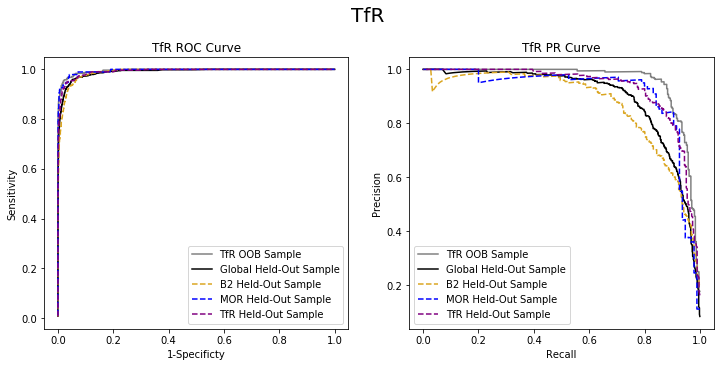

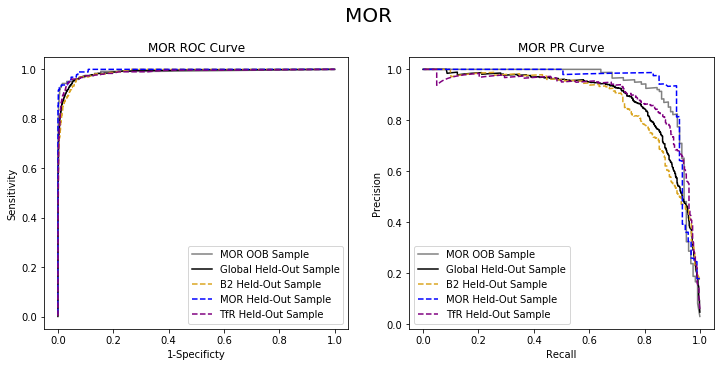

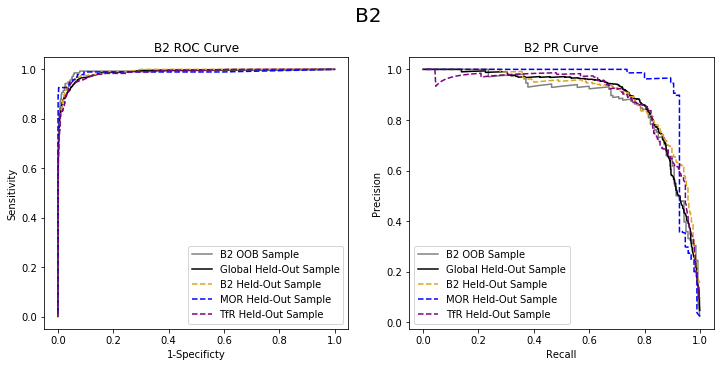

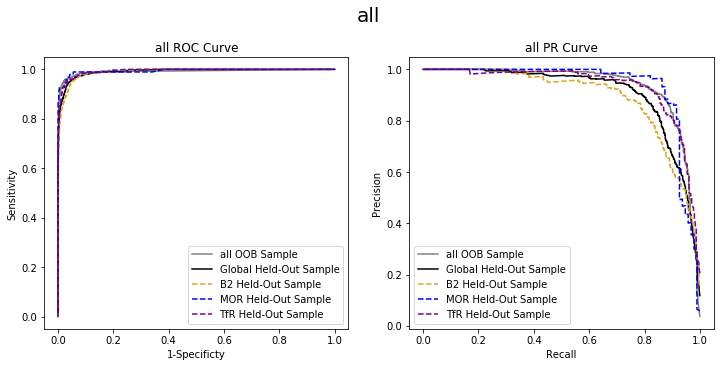

In [37]:
# classifier performance on current labeled dataset
for cargo in cargoes:
    rf = classifiers[cargo]['classifier']

    plot_roc_and_pr_curves(rf, cargo, cargoes[cargo]['training_data']['isPuff'],
                      cargoes['all']['heldout_data']['isPuff'], cargoes['all']['heldout_data'][training_fields],
                      cargoes['B2']['heldout_data']['isPuff'], cargoes['B2']['heldout_data'][training_fields],
                      cargoes['MOR']['heldout_data']['isPuff'], cargoes['MOR']['heldout_data'][training_fields],
                      cargoes['TfR']['heldout_data']['isPuff'], cargoes['TfR']['heldout_data'][training_fields])


for field, importance in zip(training_fields, classifiers['all']['classifier'].feature_importances_):
    print(field + ": " + str(importance))

/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


<Figure size 432x288 with 0 Axes>

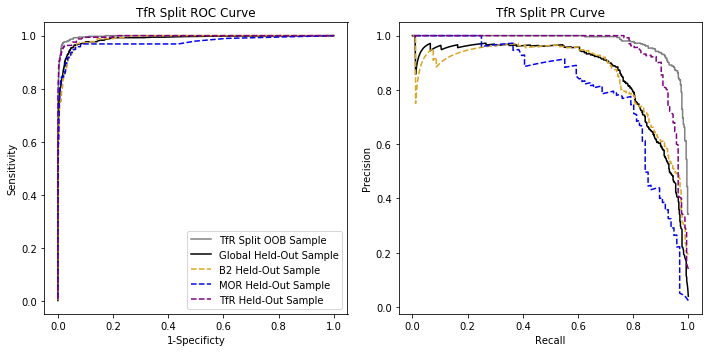

<Figure size 432x288 with 0 Axes>

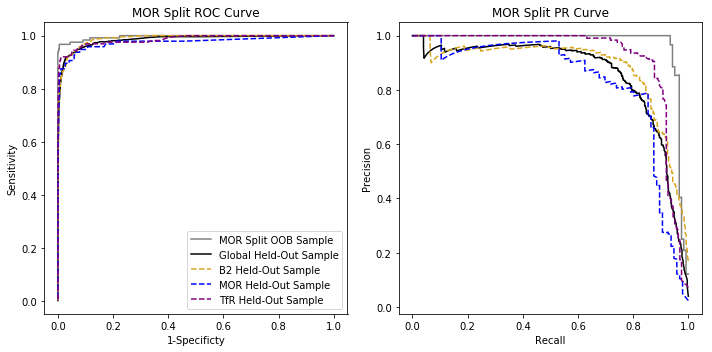

<Figure size 432x288 with 0 Axes>

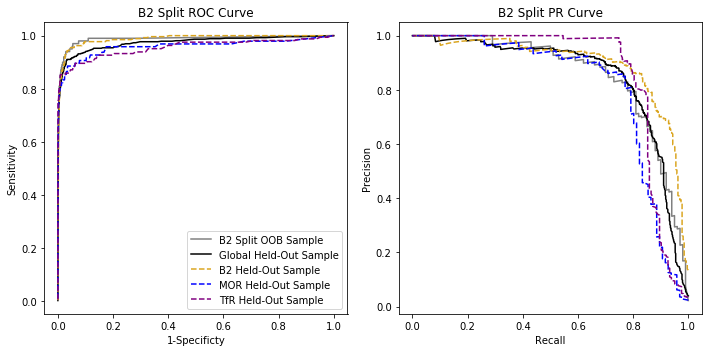

<Figure size 432x288 with 0 Axes>

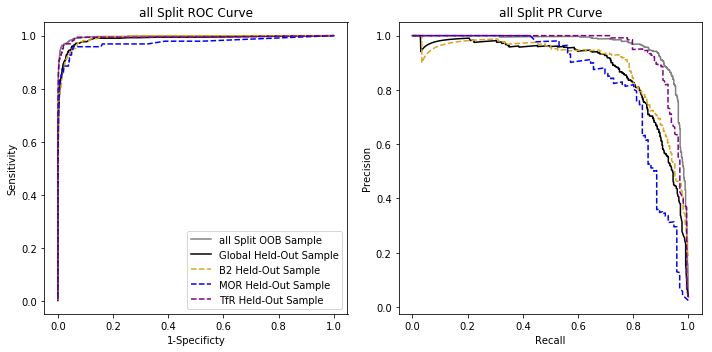

hpeaks: 0.020121821177547062
php: 0.025159489843104673
cdiff: 0.11343654012618934
pfallR2: 0.029829310082926882
pvp: 0.00539707253007011
pallAcdiff: 0.18465124515052656
npeaks: 0.006634986166583708
tnpeaks: 0.008246457101182008
percentC: 0.12598928952793917
MotionAnalysis: 0.011341850692640909
ttp: 0.012030184855631378
RSSm: 0.026813799644582186
deltaf: 0.25300990637755233
global_background: 0.014497498684091182
SNR: 0.16284054803943251


In [14]:
# classifier performance on current labeled dataset
for cargo in cargoes_without_split:
    rf = classifiers_unsplit[cargo]['classifier']

    plot_roc_and_pr_curves(rf, cargo + ' Split', cargoes_without_split[cargo]['training_data']['isPuff'],
                      cargoes_without_split['all']['heldout_data']['isPuff'], cargoes_without_split['all']['heldout_data'][training_fields],
                      cargoes_without_split['B2']['heldout_data']['isPuff'], cargoes_without_split['B2']['heldout_data'][training_fields],
                      cargoes_without_split['MOR']['heldout_data']['isPuff'], cargoes_without_split['MOR']['heldout_data'][training_fields],
                      cargoes_without_split['TfR']['heldout_data']['isPuff'], cargoes_without_split['TfR']['heldout_data'][training_fields])

for field, importance in zip(training_fields, classifier['classifier'].feature_importances_):
    print(field + ": " + str(importance))

Text(0.5,0.98,'pallAcdiff')

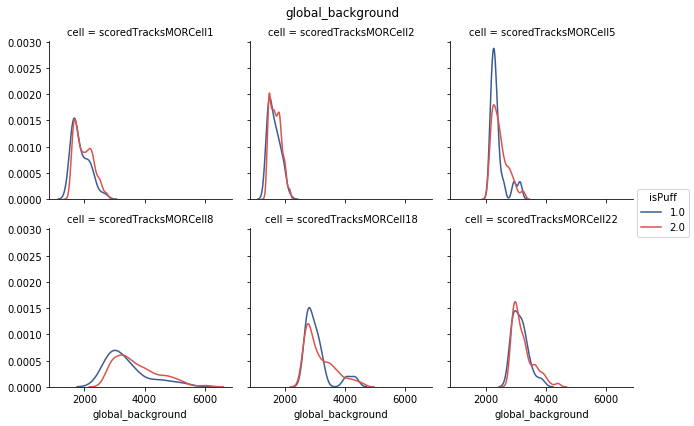

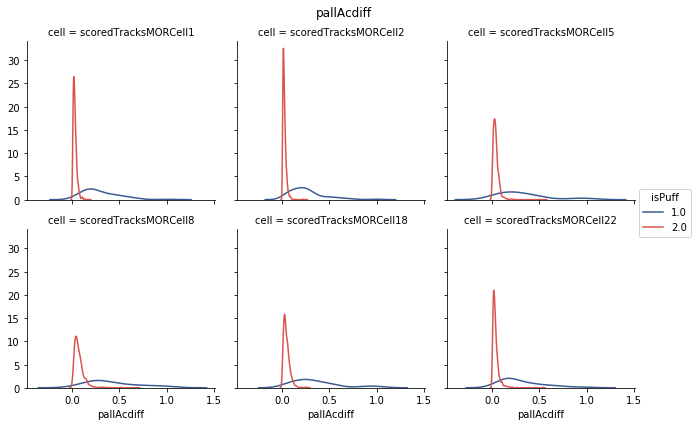

In [62]:
mor_data = cargoes['MOR']['data'].reset_index()

puffpal = [sns.xkcd_rgb["denim blue"],
           sns.xkcd_rgb["pale red"]]

g1 = sns.FacetGrid(mor_data, col='cell', col_wrap=3, hue='isPuff', palette = puffpal)
g1 = (g1.map(sns.kdeplot, 'global_background')
     .add_legend())
g1.fig.subplots_adjust(top=0.9)
g1.fig.suptitle('global_background')

g2 = sns.FacetGrid(mor_data, col='cell', col_wrap=3, hue='isPuff', palette = puffpal)
g2 = (g2.map(sns.kdeplot, 'pallAcdiff')
     .add_legend())
g2.fig.subplots_adjust(top=0.9)
g2.fig.suptitle('pallAcdiff')

In [29]:
for cell in np.unique(cargoes['all']['data'].index.get_level_values('cell')):
    cell_data = cargoes['all']['data'].xs(cell, level=1)
    print(cell + ' ' + 
          str(np.shape(np.nonzero(cell_data['isPuff']==1))[1]) + ' ' +
          str(np.mean(cell_data['global_background'])))

scoredTracksB2Cell11 48 1600.2625477614629
scoredTracksB2Cell12 63 1706.6934736687185
scoredTracksB2Cell14 37 1415.6648136434876
scoredTracksB2Cell3 266 2748.278329341511
scoredTracksB2Cell4 50 2744.8483708196154
scoredTracksMORCell1 60 1974.4902171178828
scoredTracksMORCell18 17 3153.2992980368394
scoredTracksMORCell2 61 1678.5446424521106
scoredTracksMORCell22 45 3223.0117729343006
scoredTracksMORCell5 17 2461.0006166941616
scoredTracksMORCell8 18 3730.444146085323
scoredTracksTfRRachelCell14 152 3064.789979721345
scoredTracksTfRRachelCell8 231 3981.7000721428194
scoredTracksTfRZYWCell13 31 8434.847955493207
scoredTracksTfRZYWCell2 15 8867.469610146873
scoredTracksTfRZYWCell6 120 6984.711533829992


In [ ]:
#classifier performance when trained on all data:
classifier = {}
test_fields = ['hpeaks', 'php', 'cdiff', 'pfallR2', 'pvp', 'pallAcdiff', 'npeaks', 'tnpeaks', 'percentC','MotionAnalysis', 'ttp', 'RSSm']
classifier['scores'] = cargoes['all']['training_data']['isPuff']
classifier['features'] = cargoes['all']['training_data'][test_fields]
classifier['classifier'] = RandomForestClassifier(
    n_estimators = 2000, 
    oob_score = True, 
    class_weight="balanced", 
    random_state=237)
classifier['classifier'].fit(
    classifier['features'],
    classifier['scores'])

rf = classifier['classifier']

plot_roc_and_pr_curves(rf, 'all', cargoes['all']['training_data']['isPuff'],
                      cargoes['all']['heldout_data']['isPuff'], cargoes['all']['heldout_data'][test_fields],
                      cargoes['B2']['heldout_data']['isPuff'], cargoes['B2']['heldout_data'][test_fields],
                      cargoes['MOR']['heldout_data']['isPuff'], cargoes['MOR']['heldout_data'][test_fields],
                      cargoes['TfR']['heldout_data']['isPuff'], cargoes['TfR']['heldout_data'][test_fields])

for field, importance in zip(test_fields, classifier['classifier'].feature_importances_):
    print(field + ": " + str(importance))

In [ ]:
for thresh in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]:
    df = pd.DataFrame(compute_metrics(classifiers['all'], cargoes, thresh))
    s = df.style.applymap(color_scale, subset=pd.IndexSlice['FPR',:], low=0, high=0.03)\
                .applymap(color_scale, subset=pd.IndexSlice[['AUC','Accuracy','Precision','Recall'],:], low=1, high=0.5)
    print('For threshold=' + str(thresh))
    display(HTML(s.render()))

/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


<Figure size 432x288 with 0 Axes>

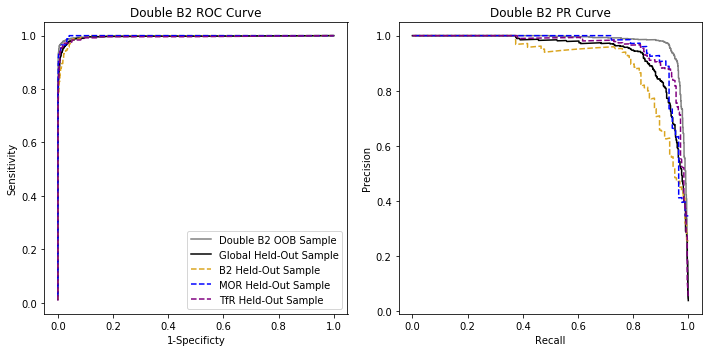

/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


<Figure size 432x288 with 0 Axes>

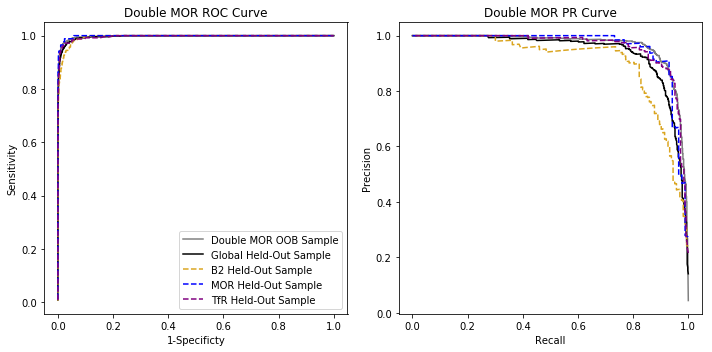

/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


<Figure size 432x288 with 0 Axes>

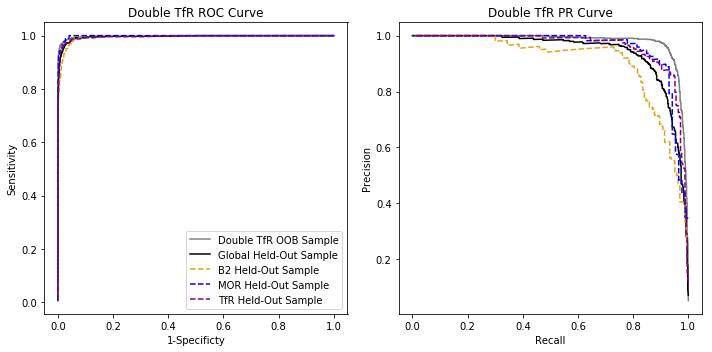

In [16]:
# changing the percentage of a cargo in the training data appears not to dramatically impact performance
for cargo in ['B2', 'MOR', 'TfR']:
    training_data_doubled = pd.concat([cargoes[cargo]['training_data'],
                                       cargoes['all']['training_data']])

    rf = RandomForestClassifier(
        n_estimators = 2000,
        oob_score = True,
        class_weight="balanced",
        random_state=237)
    rf.fit(training_data_doubled[training_fields],
           training_data_doubled['isPuff'])
    
    classifier = {'classifier' : rf, 
                  'features': training_data_doubled[training_fields], 
                  'scores' : training_data_doubled['isPuff']}

    plot_roc_and_pr_curves(rf, 'Double ' + cargo, training_data_doubled['isPuff'],
                              cargoes['all']['heldout_data']['isPuff'], cargoes['all']['heldout_data'][training_fields],
                              cargoes['B2']['heldout_data']['isPuff'], cargoes['B2']['heldout_data'][training_fields],
                              cargoes['MOR']['heldout_data']['isPuff'], cargoes['MOR']['heldout_data'][training_fields],
                              cargoes['TfR']['heldout_data']['isPuff'], cargoes['TfR']['heldout_data'][training_fields])

/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


<Figure size 432x288 with 0 Axes>

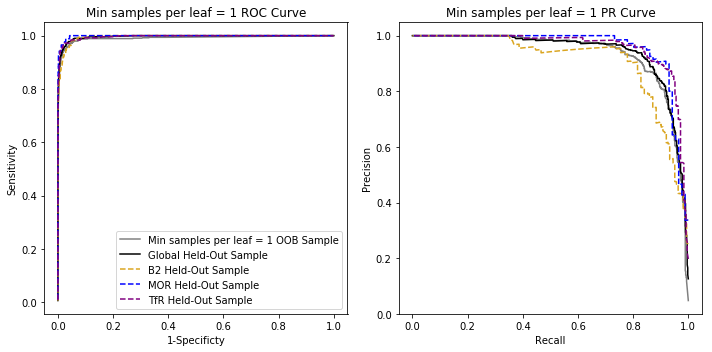

/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


<Figure size 432x288 with 0 Axes>

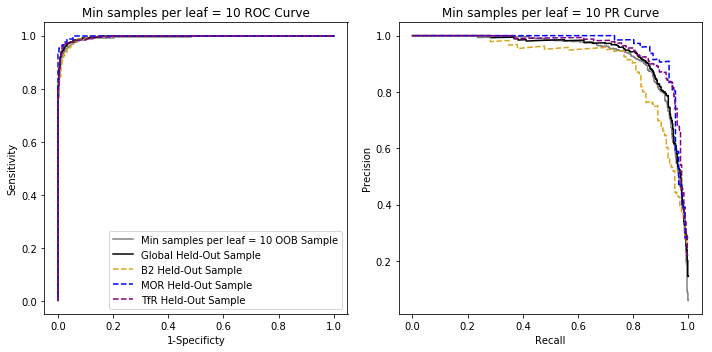

/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


<Figure size 432x288 with 0 Axes>

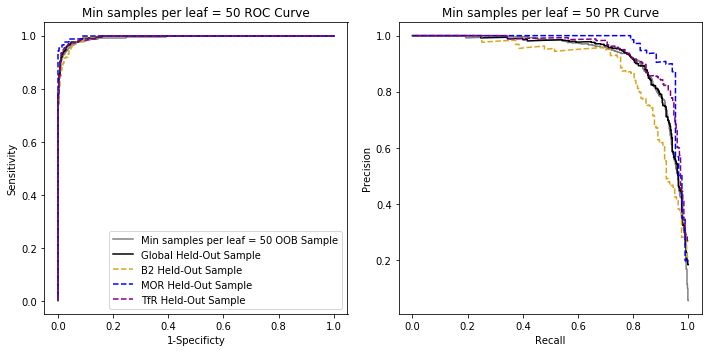

In [17]:
# Changing the number of nodes i
for num_nodes in [1, 10, 50]:
    rf = RandomForestClassifier(
        n_estimators = 2000,
        oob_score = True,
        class_weight="balanced",
        random_state=237,
        min_samples_leaf=num_nodes)
    rf.fit(cargoes['all']['training_data'][training_fields],
           cargoes['all']['training_data']['isPuff'])
    
    classifier = {'classifier' : rf, 
                  'features': cargoes['all']['training_data'][training_fields], 
                  'scores' : cargoes['all']['training_data']['isPuff']}

    plot_roc_and_pr_curves(rf, 'Min samples per leaf = ' + str(num_nodes), cargoes['all']['training_data']['isPuff'],
                              cargoes['all']['heldout_data']['isPuff'], cargoes['all']['heldout_data'][training_fields],
                              cargoes['B2']['heldout_data']['isPuff'], cargoes['B2']['heldout_data'][training_fields],
                              cargoes['MOR']['heldout_data']['isPuff'], cargoes['MOR']['heldout_data'][training_fields],
                              cargoes['TfR']['heldout_data']['isPuff'], cargoes['TfR']['heldout_data'][training_fields])

Basal frequency of puffs in B2 dataset is 0.036572
Basal frequency of puffs in MOR dataset is 0.021235
Basal frequency of puffs in TfR dataset is 0.053726


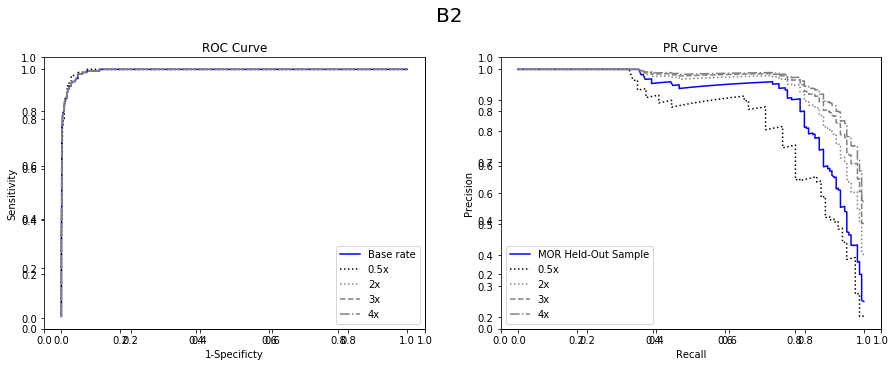

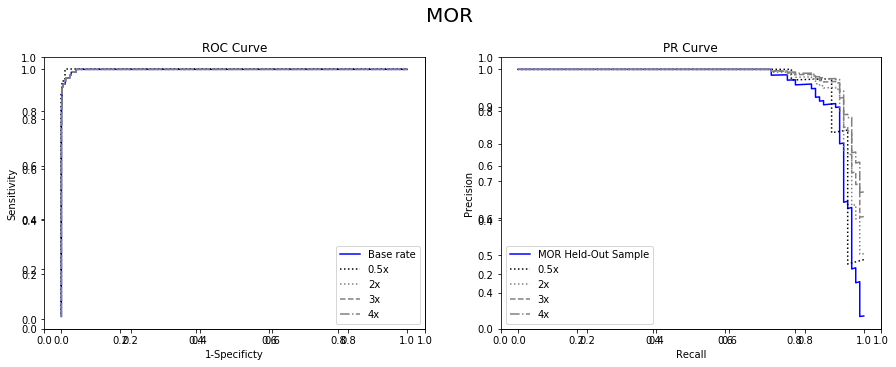

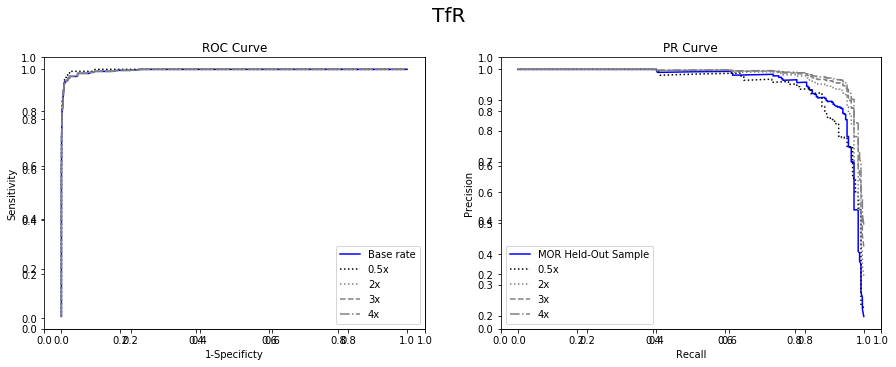

In [57]:
# Changing frequency of puffs in a dataset:

rf = classifiers['all']['classifier']

for cargo in ['B2', 'MOR', 'TfR']:
    total_events_mor = len(cargoes[cargo]['heldout_data'])
    num_puffs = len(cargoes[cargo]['heldout_data'][cargoes[cargo]['heldout_data']['isPuff']==1])
    print('Basal frequency of puffs in ' + cargo + ' dataset is %f' % (num_puffs/total_events_mor))

    MOR_heldout_features = cargoes[cargo]['heldout_data'][training_fields]
    MOR_heldout_scores = cargoes[cargo]['heldout_data']['isPuff']

    # Create versions with 0.5, 2x, 3x, and 4x more puffs
    r = np.random.RandomState(732)
    puffs = np.nonzero(np.squeeze([cargoes[cargo]['heldout_data']['isPuff']==1]))
    halfx = pd.concat([cargoes[cargo]['heldout_data'][cargoes[cargo]['heldout_data']['isPuff']==2],
                       cargoes[cargo]['heldout_data'].iloc[r.choice(np.squeeze(puffs), len(np.transpose(puffs))//2),:]])
    twox = pd.concat([cargoes[cargo]['heldout_data'][cargoes[cargo]['heldout_data']['isPuff']==1],
                      cargoes[cargo]['heldout_data']])
    threex = pd.concat([cargoes[cargo]['heldout_data'][cargoes[cargo]['heldout_data']['isPuff']==1],
                        twox])
    fourx = pd.concat([cargoes[cargo]['heldout_data'][cargoes[cargo]['heldout_data']['isPuff']==1],
                       threex])

    fig, [ax1, ax2] = plt.subplots(1,2,figsize=(15,5))
    fig.suptitle(cargo, y=1.02, fontsize=20)
    ax1 = fig.add_subplot(121)
    ax1.set_xlabel('1-Specificty')
    ax1.set_ylabel('Sensitivity')
    ax2 = fig.add_subplot(122)
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')

    probas_ = rf.predict_proba(MOR_heldout_features)
    fpr, tpr , thresholds= roc_curve(MOR_heldout_scores, probas_[:,0], pos_label = 1)
    ax1.plot(fpr,tpr,'blue', ls='-', label='Base rate')
    probas_ = rf.predict_proba(halfx[training_fields])
    fpr, tpr , thresholds= roc_curve(halfx['isPuff'], probas_[:,0], pos_label = 1)
    ax1.plot(fpr,tpr,'black', ls=':', label='0.5x')
    probas_ = rf.predict_proba(twox[training_fields])
    fpr, tpr , thresholds= roc_curve(twox['isPuff'], probas_[:,0], pos_label = 1)
    ax1.plot(fpr,tpr,'gray', ls=':', label='2x')
    probas_ = rf.predict_proba(threex[training_fields])
    fpr, tpr , thresholds= roc_curve(threex['isPuff'], probas_[:,0], pos_label = 1)
    ax1.plot(fpr,tpr,'gray', ls='--', label='3x')
    probas_ = rf.predict_proba(fourx[training_fields])
    fpr, tpr , thresholds= roc_curve(fourx['isPuff'], probas_[:,0], pos_label = 1)
    ax1.plot(fpr,tpr,'gray', ls='-.', label='4x')

    probas_ = rf.predict_proba(MOR_heldout_features)
    precision, recall, thresholds = precision_recall_curve(MOR_heldout_scores, probas_[:,0],pos_label = 1)
    ax2.plot(recall,precision, 'blue', ls='-', label='MOR Held-Out Sample')
    probas_ = rf.predict_proba(halfx[training_fields])
    precision, recall, thresholds = precision_recall_curve(halfx['isPuff'], probas_[:,0], pos_label = 1)
    ax2.plot(recall,precision,'black', ls=':', label='0.5x')
    probas_ = rf.predict_proba(twox[training_fields])
    precision, recall, thresholds = precision_recall_curve(twox['isPuff'], probas_[:,0], pos_label = 1)
    ax2.plot(recall,precision,'gray', ls=':', label='2x')
    probas_ = rf.predict_proba(threex[training_fields])
    precision, recall, thresholds = precision_recall_curve(threex['isPuff'], probas_[:,0], pos_label = 1)
    ax2.plot(recall,precision,'gray', ls='--', label='3x')
    probas_ = rf.predict_proba(fourx[training_fields])
    precision, recall, thresholds = precision_recall_curve(fourx['isPuff'], probas_[:,0], pos_label = 1)
    ax2.plot(recall,precision,'gray', ls='-.', label='4x')

    ax1.legend()
    ax1.set_title('ROC Curve')
    ax2.set_title('PR Curve')
    ax2.legend()

In [18]:
def rfkernel_gram_matrix(leaves_mat, progress = False):
    """
    calculates the random forest kernel gram matrix 

    Keyword arguments:
    leaves_mat -- n_test data points stored in an n_test x n_tree np.array
    """
    n_tree = leaves_mat.shape[1]
    n_obs  = leaves_mat.shape[0]

    gram_matrix = np.zeros((n_obs,n_obs))

    if progress:
        bar = progressbar.ProgressBar()
        first_iter = bar(np.arange(n_tree))
    else:
        first_iter = np.arange(n_tree)


    for tree_step in first_iter:
        for leaf_step in set(leaves_mat[:,tree_step]):
            desired_index = np.where(leaves_mat[:,tree_step] == leaf_step)[0]
            add_to_mat(mat = gram_matrix,
                       common = desired_index,
                       value = 1)

    return(gram_matrix/n_tree)

def add_to_mat(mat, common, value, return_mat = False):
    """
    fills mat with specific value (in a common tuples positions)
    """
    for x,y in itertools.product(common,common):
        mat[x,y] += value
    if return_mat:
        return mat

all_leaves = classifiers['all']['classifier'].apply(X = cargoes['all']['heldout_data'][training_fields])
all_gm = rfkernel_gram_matrix(all_leaves, progress = True)
    
puffs_mask = cargoes['all']['heldout_data']['isPuff']==1
puffs_leaves = classifiers['all']['classifier'].apply(X = cargoes['all']['heldout_data'][puffs_mask][training_fields]) 
puffs_gm = rfkernel_gram_matrix(puffs_leaves, progress = True)

nonpuffs_mask = np.invert(puffs_mask)
nonpuffs_leaves = classifiers['all']['classifier'].apply(X = cargoes['all']['heldout_data'][nonpuffs_mask][training_fields]) 
nonpuffs_gm = rfkernel_gram_matrix(nonpuffs_leaves, progress = True)

  0% (1 of 2000) |                        | Elapsed Time: 0:00:10 ETA:  6:05:44

KeyboardInterrupt: 

In [ ]:
mds_class = sklearn.manifold.MDS(dissimilarity = "precomputed", n_jobs = 2, random_state=237)
fit_mds_all = mds_class.fit_transform(1 - all_gm)
fit_mds_puffs = mds_class.fit_transform(1 - puffs_gm)
fit_mds_nonpuffs = mds_class.fit_transform(1 - nonpuffs_gm)

tsne_class = sklearn.manifold.TSNE(metric = "precomputed", random_state=237)
fit_tsne_all = tsne_class.fit_transform(1 - all_gm)
fit_tsne_puffs = tsne_class.fit_transform(1 - puffs_gm)
fit_tsne_nonpuffs = tsne_class.fit_transform(1 - nonpuffs_gm)

In [ ]:
plt.clf()
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title('MDS of Puffs vs NonPuffs')
color_options = {'puff' : sns.xkcd_rgb["denim blue"], 'non-puff' : sns.xkcd_rgb["pale red"]}
for category, value in {'non-puff' : 2., 'puff' : 1.}.items():
    plt.plot(fit_mds_all[cargoes['all']['heldout_data']['isPuff'] == value,0],
             fit_mds_all[cargoes['all']['heldout_data']['isPuff'] == value,1],
             color = color_options[category], marker=".", ls="None", alpha = .6, label=category)
plt.legend()

plt.subplot(122)
color_options = {'B2' : 'goldenrod', 'MOR' : 'blue', 'TfR' : 'Purple'}
plt.title('MDS of Puffs Across Cargos')
for cargo in ['B2','TfR','MOR']:
    filt = ((cargoes['all']['heldout_data']['isPuff']==1.) & 
            (cargoes['all']['heldout_data'].index.get_level_values('cargo') == cargo))
    plt.plot(fit_mds_all[filt,0],
            fit_mds_all[filt,1],
            color = color_options[cargo], marker='.', ls='None', alpha = .6, label=cargo)
plt.legend()
plt.show()

In [ ]:
plt.clf()
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title('tSNE of Puffs vs NonPuffs')
color_options = {'puff' : sns.xkcd_rgb["denim blue"], 'non-puff' : sns.xkcd_rgb["pale red"]}
for category, value in {'non-puff' : 2., 'puff' : 1.}.items():
    plt.plot(fit_tsne_all[cargoes['all']['heldout_data']['isPuff'] == value,0],
             fit_tsne_all[cargoes['all']['heldout_data']['isPuff'] == value,1],
             color = color_options[category], marker=".", ls="None", alpha = .6, label=category)
plt.legend()

plt.subplot(122)
color_options = {'B2' : 'goldenrod', 'MOR' : 'blue', 'TfR' : 'Purple'}
plt.title('tSNE of Puffs Across Cargos')
for cargo in ['B2','TfR','MOR']:
    filt = ((cargoes['all']['heldout_data']['isPuff']==1.) & 
            (cargoes['all']['heldout_data'].index.get_level_values('cargo') == cargo))
    plt.plot(fit_tsne_all[filt,0],
             fit_tsne_all[filt,1],
             color = color_options[cargo], marker='.', ls='None', alpha = .6, label=cargo)
plt.legend()
plt.show()

In [ ]:
filt_by_tsne = (((fit_tsne_all[:,1] >= 10) |
                (fit_tsne_all[:,1] <= -25)) &
                (cargoes['all']['heldout_data']['isPuff']==1.))
weird_puffs = cargoes['all']['heldout_data'][filt_by_tsne]
with pd.option_context('display.max_rows', None):
    print(weird_puffs.index.to_series())

In [ ]:
plt.clf()
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title('MDS of Non-Puffs by Cargo')
color_options = {'B2' : 'goldenrod', 'MOR' : 'blue', 'TfR' : 'Purple'}
for cargo in ['B2','TfR','MOR']:
    filt = (cargoes['all']['heldout_data'][nonpuffs_mask].index.get_level_values('cargo') == cargo)
    plt.plot(fit_mds_nonpuffs[filt,0],
             fit_mds_nonpuffs[filt,1],
             color = color_options[cargo], marker='.', ls='None', alpha = .6, label=cargo)
plt.legend()

plt.subplot(122)
plt.title('tSNE of Non-Puffs by Cargo')
color_options = {'B2' : 'goldenrod', 'MOR' : 'blue', 'TfR' : 'Purple'}
for cargo in ['B2','TfR','MOR']:
        filt = (cargoes['all']['heldout_data'][nonpuffs_mask].index.get_level_values('cargo') == cargo)
        plt.plot(fit_tsne_nonpuffs[filt,0],
                 fit_tsne_nonpuffs[filt,1],
                 color = color_options[cargo], marker='.', ls='None', alpha = .6, label=cargo)
plt.legend()
plt.show()

In [ ]:
plt.clf()
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title('MDS of Puffs by Cargo')
color_options = {'B2' : 'goldenrod', 'MOR' : 'blue', 'TfR' : 'Purple'}
for cargo in ['B2','TfR','MOR']:
    filt = (cargoes['all']['heldout_data'][puffs_mask].index.get_level_values('cargo') == cargo)
    plt.plot(fit_mds_puffs[filt,0],
             fit_mds_puffs[filt,1],
             color = color_options[cargo], marker='.', ls='None', alpha = .6, label=cargo)
plt.legend()

plt.subplot(122)
plt.title('tSNE of Puffs by Cargo')
color_options = {'B2' : 'goldenrod', 'MOR' : 'blue', 'TfR' : 'Purple'}
for cargo in ['B2','TfR','MOR']:
        filt = (cargoes['all']['heldout_data'][puffs_mask].index.get_level_values('cargo') == cargo)
        plt.plot(fit_tsne_puffs[filt,0],
                 fit_tsne_puffs[filt,1],
                 color = color_options[cargo], marker='.', ls='None', alpha = .6, label=cargo)
plt.legend()
plt.show()

In [13]:
puffpal = [sns.xkcd_rgb["pale red"],
           sns.xkcd_rgb["denim blue"]]

training_fields = ['hpeaks', 'php', 'cdiff', 'pfallR2', 'pvp', 'pallAcdiff', 'npeaks', 
                   'tnpeaks', 'percentC','MotionAnalysis', 'ttp', 'RSSm', 'deltaf',
                   'global_background', 'SNR']

probas = classifiers['all']['classifier'].predict_proba(cargoes['all']['heldout_data'][training_fields])

all_with_probas = pd.concat([cargoes['all']['heldout_data'],
                             pd.Series(probas[:,0],
                                       name = 'probas',
                                       index = cargoes['all']['heldout_data'].index)],  axis=1)

g = sns.FacetGrid(all_with_probas, hue='isPuff', palette=puffpal, 
                  col='probas', row = training_fields, hue_order = [2., 1.])
g.map(plt.scatter)

TypeError: Argument 'obj' has incorrect type (expected list, got DataFrame)

/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


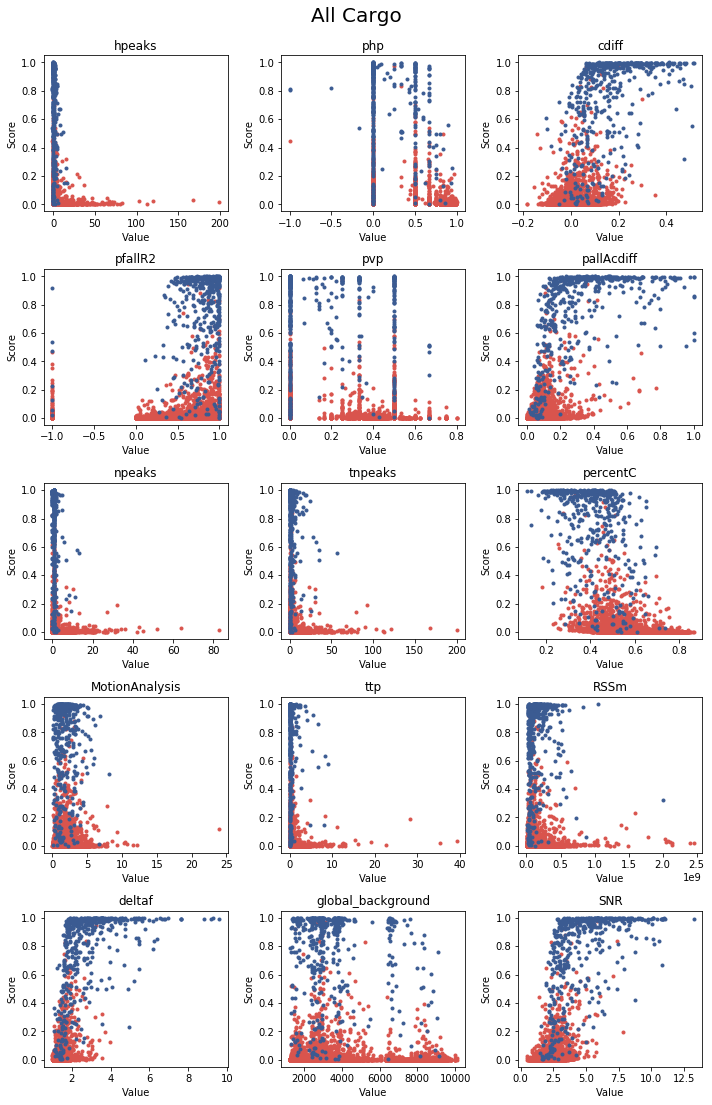

In [19]:
probas = classifiers['all']['classifier'].predict_proba(cargoes['all']['heldout_data'][training_fields])

color_options = {'puff' : sns.xkcd_rgb["denim blue"], 'non-puff' : sns.xkcd_rgb["pale red"]}

fig, axes = plt.subplots(math.ceil(np.shape(training_fields)[0]/3),
                         3)
fig.set_tight_layout(True)
fig.set_size_inches(10,15)
fig.suptitle('All Cargo', y=1.02, fontsize=20)

for counter, feature in enumerate(training_fields):
    axes.ravel()[counter].set_xlabel('Value')
    axes.ravel()[counter].set_ylabel('Score')
    axes.ravel()[counter].set_xscale('linear')
    axes.ravel()[counter].set_title(feature)
    for category, value in {'non-puff' : 2., 'puff' : 1.}.items():
        values = []
        scores = []
        events = cargoes['all']['heldout_data'][cargoes['all']['heldout_data']['isPuff']==value]
        for idx, row in enumerate(events.itertuples()):
            values.append(getattr(row,feature))
            scores.append(probas[cargoes['all']['heldout_data'].index.get_loc(getattr(row,'Index')),0])
        axes.ravel()[counter].plot(values,scores,marker='.', ls='None', color=color_options[category])
    fig.show()

/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


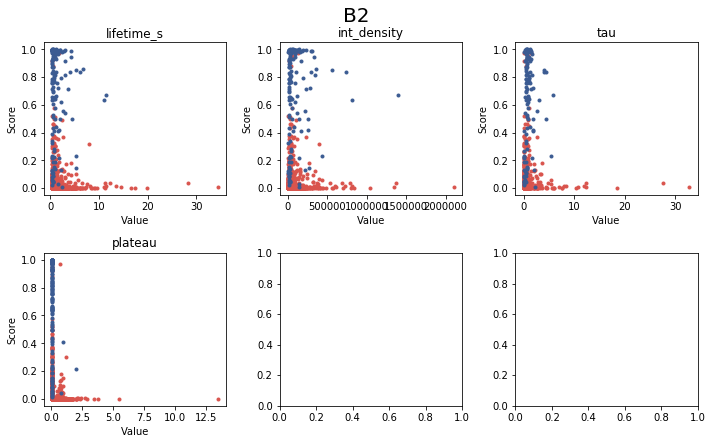

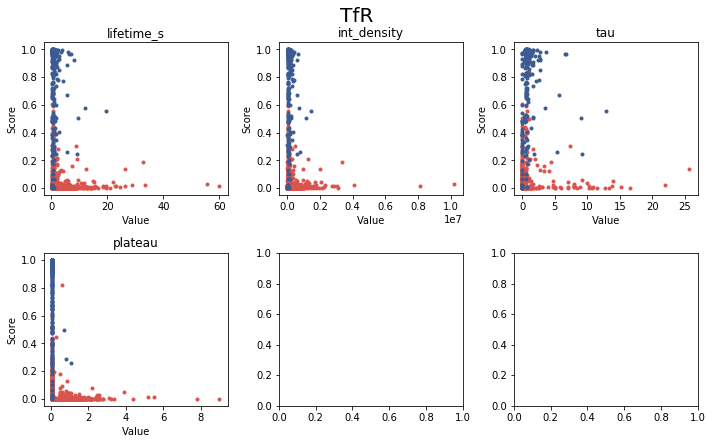

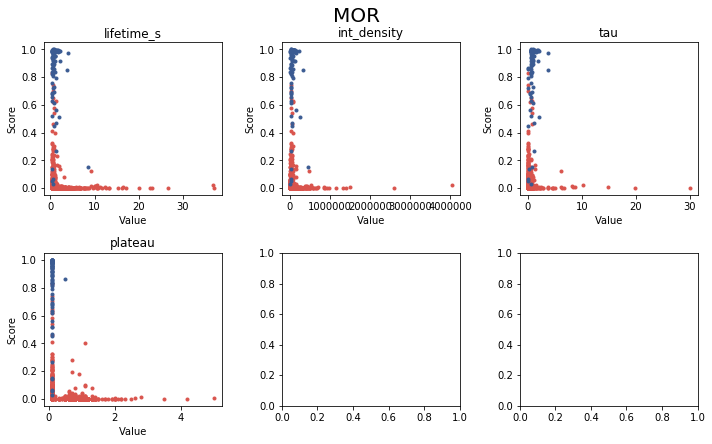

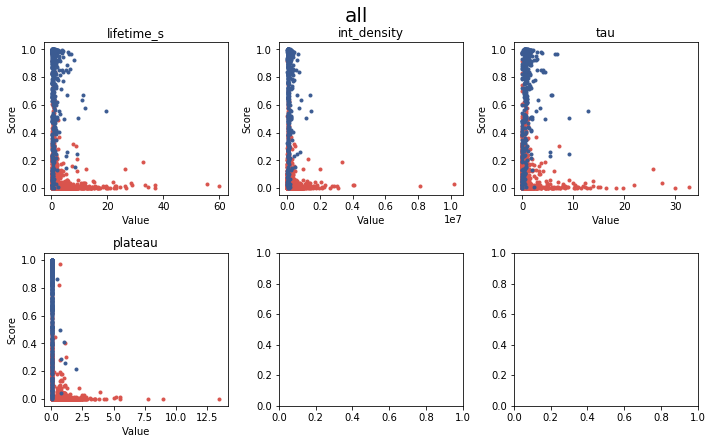

In [23]:
color_options = {'puff' : sns.xkcd_rgb["denim blue"], 'non-puff' : sns.xkcd_rgb["pale red"]}

features = ['lifetime_s', 'int_density', 'tau', 'plateau']

for cargo in ['B2', 'TfR', 'MOR', 'all']:
    probas = classifiers['all']['classifier'].predict_proba(cargoes[cargo]['heldout_data'][training_fields])
    
    fig, axes = plt.subplots(math.ceil(np.shape(features)[0]/3),
                             3)
    fig.set_tight_layout(True)
    fig.set_size_inches(10,6)
    fig.suptitle(cargo, y=1.02, fontsize=20)
    
    for counter, feature in enumerate(features):
        axes.ravel()[counter].set_xlabel('Value')
        axes.ravel()[counter].set_ylabel('Score')
        axes.ravel()[counter].set_xscale('linear')
        axes.ravel()[counter].set_title(feature)
        
        for category, value in {'non-puff' : 2., 'puff' : 1.}.items():
            values = []
            scores = []
            events = cargoes[cargo]['heldout_data'][cargoes[cargo]['heldout_data']['isPuff']==value]
            for idx, row in enumerate(events.itertuples()):
                values.append(getattr(row,feature))
                scores.append(probas[cargoes[cargo]['heldout_data'].index.get_loc(getattr(row,'Index')),0])
            axes.ravel()[counter].plot(values,scores,marker='.', ls='None', color=color_options[category])
            
    fig.show()

In [ ]:
from pdpbox import pdp

rf = classifiers['all']['classifier']

for feature1, feature2 in itertools.product(training_fields,training_fields):
    if feature1 == feature2:
        continue
    inter = pdp.pdp_interact(rf, cargoes['all']['training_data'][training_fields], [feature1, feature2])
    pdp.pdp_interact_plot(inter, [feature1, feature2], x_quantile=True, only_inter=True)